In [ ]:
# 1. INSTALL DEPENDENCIES
!pip install scikit-image opencv-python matplotlib
!pip install rembg
!pip install onnxruntime

# 2. IMPORT LIBRARIES
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage import exposure
from rembg import remove

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
from zipfile import ZipFile
import os

# Step 1: Upload ZIP file
from google.colab import files
uploaded = files.upload()  # Upload the ZIP file (e.g., raw_data.zip)

# Step 2: Unzip it
zip_path = next(iter(uploaded))
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Check extracted content
os.listdir('/content/raw_data')


Saving raw_data.zip to raw_data.zip


['mehdi-1.jpeg',
 'uzain.jpeg',
 'mehdi-2.jpeg',
 'mehdi-4.jpeg',
 'mehdi-3.jpeg',
 'roohan.jpeg',
 'ali.jpeg']

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from rembg import remove

# Paths
RAW_FOLDER = "raw_data"
OUTPUT_FOLDER = "processed_data"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def enhance_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return enhanced

def removeBackground(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    result = remove(pil_img)

    result_cv = cv2.cvtColor(np.array(result), cv2.COLOR_RGB2BGR)

    if result.mode == 'RGBA':
        alpha = np.array(result.split()[-1])
        mask = (alpha > 0).astype(np.uint8) * 255
    else:
        gray = cv2.cvtColor(result_cv, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)

    crop_y_start = y
    crop_y_end = y + h // 2

    cropped = result_cv[crop_y_start:crop_y_end, x:x + w]

    final = cv2.resize(cropped, (256, 256))

    enhanced = enhance_contrast(result_cv)

    cv2.imwrite(output_path, enhanced)
    print("✅ Background removed and saved as output_no_bg.png")

def process_image(img_path, output_path):
    img = cv2.imread(img_path)
    if img is None:
      return

    oImage = removeBackground(img)

# Process all images in raw_data/
for filename in os.listdir(RAW_FOLDER):
    if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
        input_path = os.path.join(RAW_FOLDER, filename)
        output_path = os.path.join(OUTPUT_FOLDER, filename)
        process_image(input_path, output_path)

print("✅ Preprocessing complete. Check processed_data/ for results.")


✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Background removed and saved as output_no_bg.png
✅ Preprocessing complete. Check processed_data/ for results.


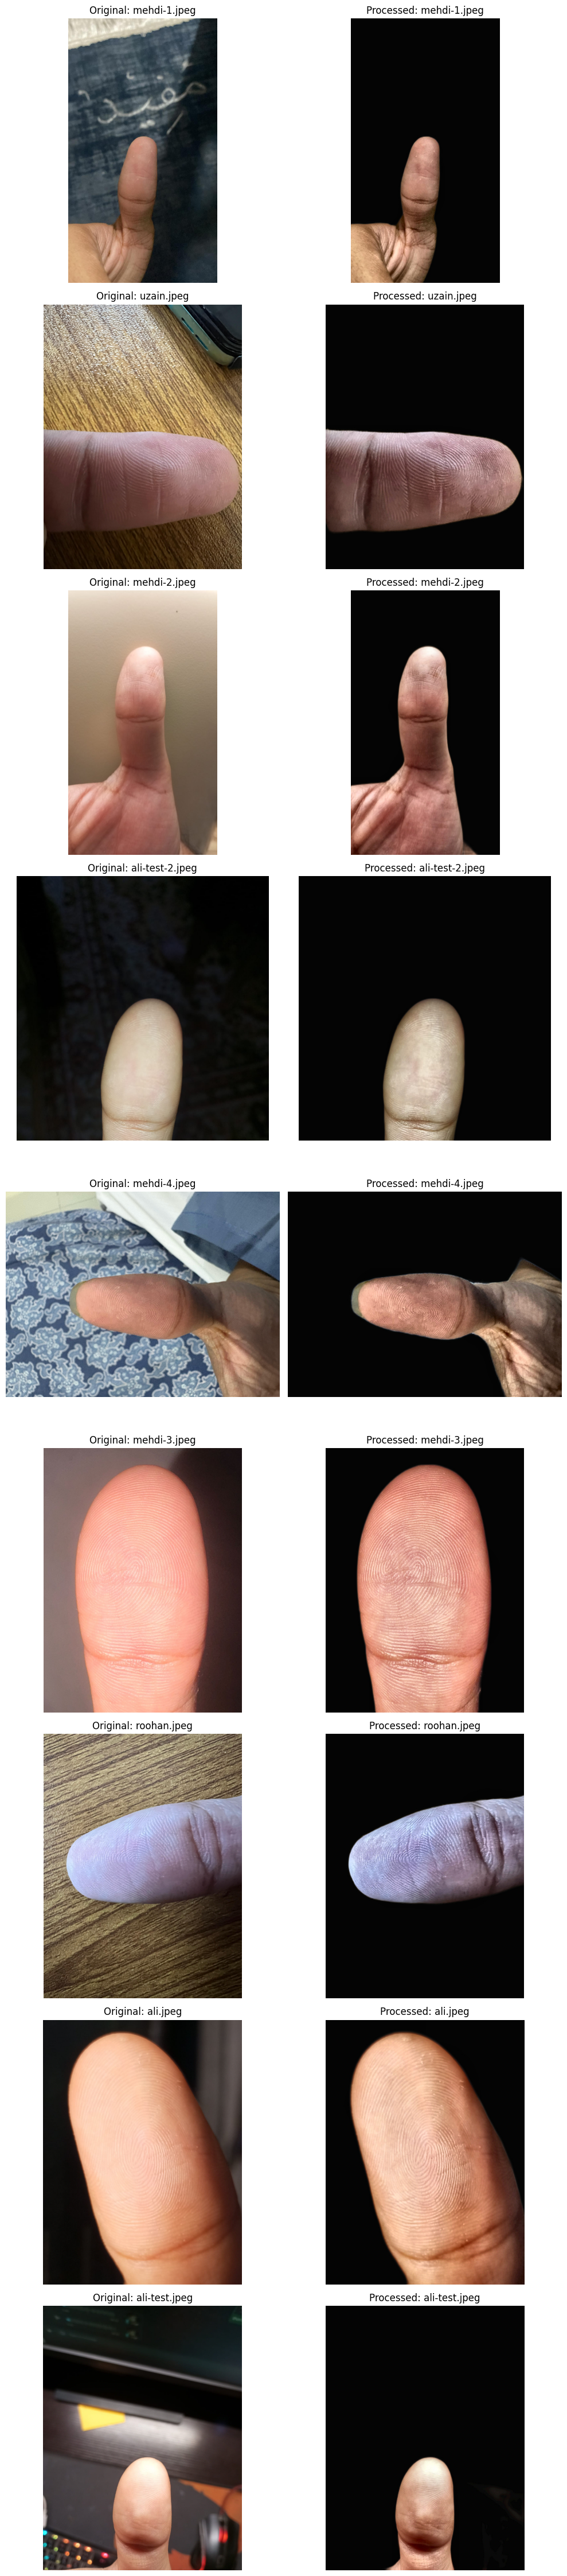

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Collect all image files
raw_files = [f for f in os.listdir("raw_data") if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not raw_files:
    print("No image files found in raw_data/")
else:
    num_images = len(raw_files)
    plt.figure(figsize=(10, 5 * num_images))  # Adjust height based on number of images

    for idx, filename in enumerate(raw_files):
        raw_path = os.path.join("raw_data", filename)
        proc_path = os.path.join("processed_data", filename)

        img_orig = cv2.imread(raw_path)
        img_proc = cv2.imread(proc_path)

        if img_orig is None or img_proc is None:
            print(f"Could not read file: {filename}")
            continue

        # Plot original
        plt.subplot(num_images, 2, 2 * idx + 1)
        plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {filename}")
        plt.axis('off')

        # Plot processed
        plt.subplot(num_images, 2, 2 * idx + 2)
        plt.imshow(cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB))
        plt.title(f"Processed: {filename}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import cv2
from matplotlib import pyplot as plt


class FingerprintMatcher:
    def __init__(self, data_dir):
        """
        Initialize the fingerprint matcher with the directory containing raw fingerprint images.

        Args:
            data_dir (str): Directory path containing fingerprint images
        """
        self.data_dir = data_dir
        self.fingerprint_db = (
            {}
        )  # Dictionary to store processed fingerprints and their keypoints/descriptors

        # Initialize SIFT detector
        self.sift = cv2.SIFT_create()

        # FLANN parameters for fast matching
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Load fingerprint database
        self.load_fingerprints()

    def load_fingerprints(self):
        """Load all fingerprint images from the data directory and extract SIFT features."""
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")

        print(f"Loading fingerprints from {self.data_dir}")
        for filename in os.listdir(self.data_dir):
            if filename.endswith((".png", ".jpg", ".jpeg", ".bmp")):
                filepath = os.path.join(self.data_dir, filename)
                print(f"Processing {filename}")

                # Use filename without extension as the person's identifier
                person_id = os.path.splitext(filename)[0]

                # Process the fingerprint
                processed_img = self.preprocess_image(filepath)
                keypoints, descriptors = self.extract_sift_features(processed_img)

                # Store in database
                self.fingerprint_db[person_id] = {
                    "processed_image": processed_img,
                    "keypoints": keypoints,
                    "descriptors": descriptors,
                }

        print(f"Loaded {len(self.fingerprint_db)} fingerprints")

    def preprocess_image(self, image_path):
        """
        Preprocess the fingerprint image to enhance features.

        Args:
            image_path (str): Path to the fingerprint image

        Returns:
            numpy.ndarray: Preprocessed image
        """
        # Read image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Resize to standardize image size (optional)
        img = cv2.resize(img, (500, 500))

        # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Gaussian blur to reduce noise
        img = cv2.GaussianBlur(img, (5, 5), 0)

        return img

    def extract_sift_features(self, img):
        """
        Extract SIFT features from a preprocessed image.

        Args:
            img (numpy.ndarray): Preprocessed fingerprint image

        Returns:
            tuple: (keypoints, descriptors)
        """
        # Detect keypoints and compute descriptors
        keypoints, descriptors = self.sift.detectAndCompute(img, None)

        return keypoints, descriptors

    def match(self, query_image_path, threshold=0.7, min_matches=10):
        """
        Match a query fingerprint against the database using SIFT features.

        Args:
            query_image_path (str): Path to the query fingerprint image
            threshold (float): Ratio threshold for Lowe's ratio test
            min_matches (int): Minimum number of good matches required

        Returns:
            tuple: (best_match_id, score, num_good_matches)
        """
        # Preprocess the query image
        processed_query = self.preprocess_image(query_image_path)

        # Extract SIFT features from query image
        query_keypoints, query_descriptors = self.extract_sift_features(processed_query)

        best_match = None
        highest_score = 0
        best_matches = None
        highest_matches_count = 0

        # Compare against each fingerprint in the database
        for person_id, data in self.fingerprint_db.items():
            db_keypoints = data["keypoints"]
            db_descriptors = data["descriptors"]

            if query_descriptors is None or db_descriptors is None:
                continue

            if len(query_descriptors) == 0 or len(db_descriptors) == 0:
                continue

            # Match descriptors using FLANN
            matches = self.flann.knnMatch(query_descriptors, db_descriptors, k=2)

            # Apply Lowe's ratio test to filter good matches
            good_matches = []
            for m, n in matches:
                if m.distance < threshold * n.distance:
                    good_matches.append(m)

            # Calculate match score
            score = len(good_matches) / max(len(query_keypoints), len(db_keypoints))

            print(
                f"Match score for {person_id}: {score:.4f} (good matches: {len(good_matches)})"
            )

            if (
                len(good_matches) > highest_matches_count
                and len(good_matches) >= min_matches
            ):
                highest_matches_count = len(good_matches)
                highest_score = score
                best_match = person_id
                best_matches = good_matches

        return best_match, highest_score, highest_matches_count

    def visualize_matches(self, query_image_path, match_id, save_path=None):
        """
        Visualize matching keypoints between query image and best match.

        Args:
            query_image_path (str): Path to the query fingerprint image
            match_id (str): ID of the matching fingerprint
            save_path (str, optional): Path to save the visualization
        """
        if match_id not in self.fingerprint_db:
            print(f"No match found with ID: {match_id}")
            return

        # Preprocess query image
        processed_query = self.preprocess_image(query_image_path)
        query_keypoints, query_descriptors = self.extract_sift_features(processed_query)

        # Get data for the matched fingerprint
        match_data = self.fingerprint_db[match_id]
        match_img = match_data["processed_image"]
        match_keypoints = match_data["keypoints"]
        match_descriptors = match_data["descriptors"]

        # Match descriptors
        matches = self.flann.knnMatch(query_descriptors, match_descriptors, k=2)

        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # Draw matches
        img_matches = cv2.drawMatches(
            processed_query,
            query_keypoints,
            match_img,
            match_keypoints,
            good_matches,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )

        # Display
        plt.figure(figsize=(16, 8))
        plt.imshow(img_matches)
        plt.title(
            f"Matches between query and {match_id} - {len(good_matches)} good matches"
        )
        plt.axis("off")

        if save_path:
            plt.savefig(save_path)
            print(f"Saved visualization to {save_path}")

        plt.show()

    def visualize_features(self, image_path, save_path=None):
        """
        Visualize SIFT keypoints on a fingerprint image.

        Args:
            image_path (str): Path to the fingerprint image
            save_path (str, optional): Path to save the visualization
        """
        # Preprocess the image
        processed_img = self.preprocess_image(image_path)

        # Extract SIFT features
        keypoints, _ = self.extract_sift_features(processed_img)

        # Draw keypoints
        img_with_keypoints = cv2.drawKeypoints(
            processed_img,
            keypoints,
            None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )

        # Display
        plt.figure(figsize=(8, 8))
        plt.imshow(img_with_keypoints)
        plt.title(
            f"SIFT Features: {os.path.basename(image_path)} - {len(keypoints)} keypoints"
        )
        plt.axis("off")

        if save_path:
            plt.savefig(save_path)
            print(f"Saved visualization to {save_path}")

        plt.show()

Loading fingerprints from processed_data
Processing mehdi-1.jpeg
Processing uzain.jpeg
Processing mehdi-2.jpeg
Processing ali-test-2.jpeg
Processing mehdi-4.jpeg
Processing mehdi-3.jpeg
Processing roohan.jpeg
Processing ali.jpeg
Processing ali-test.jpeg
Loaded 9 fingerprints

Visualizing SIFT features for each fingerprint:
Saved visualization to output/mehdi-1_features.png


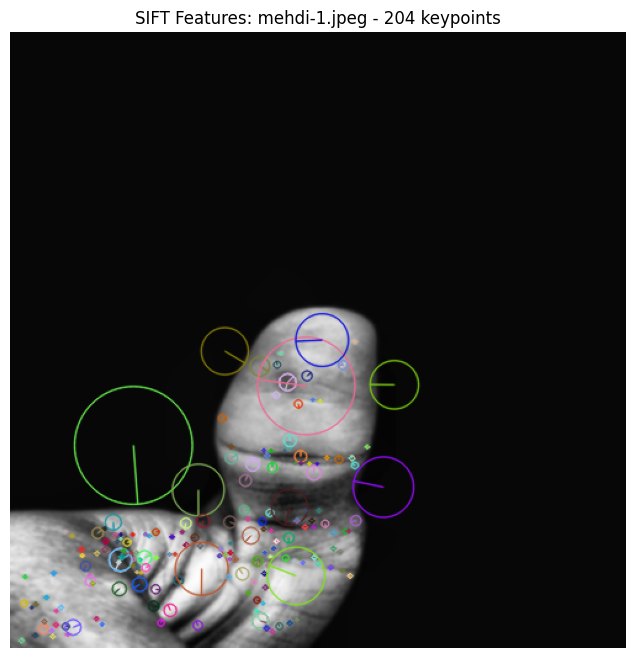

Saved visualization to output/uzain_features.png


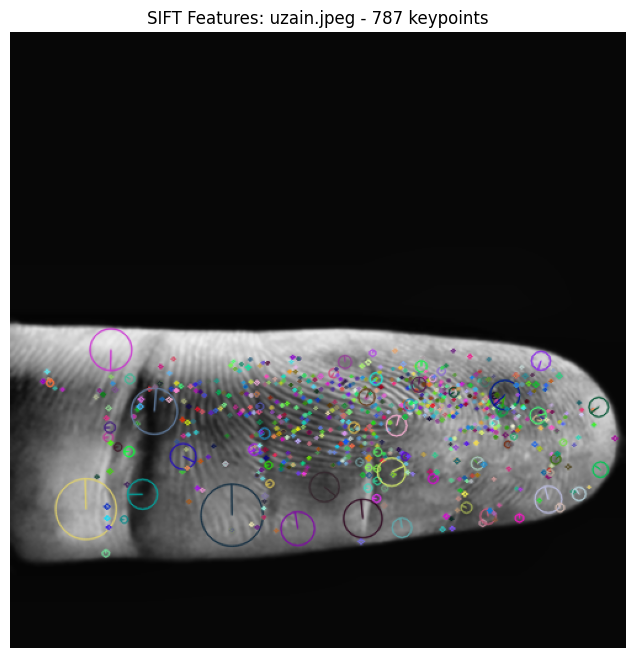

Saved visualization to output/mehdi-2_features.png


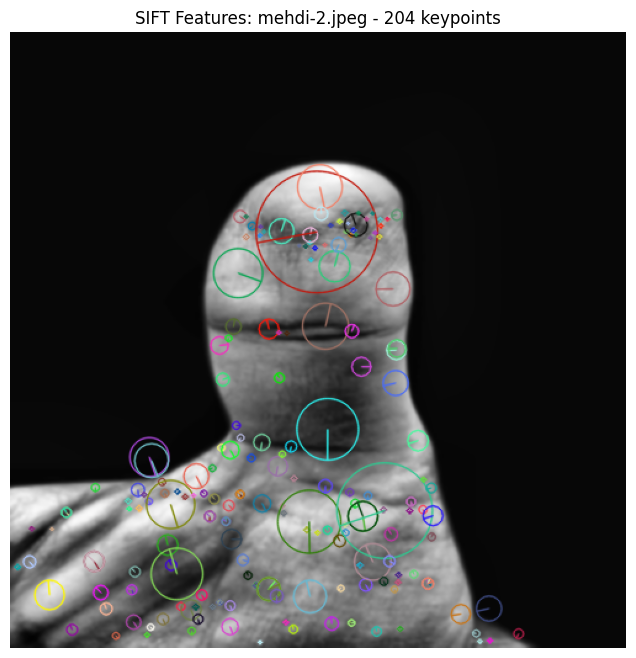

Saved visualization to output/ali-test-2_features.png


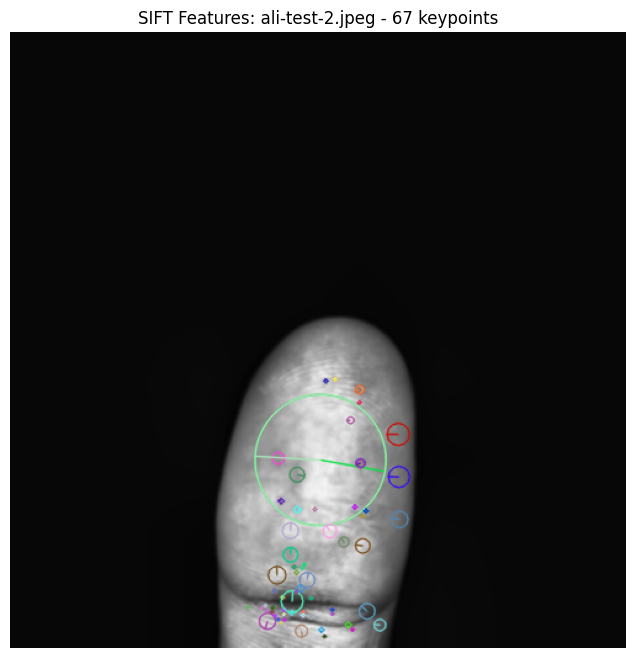

Saved visualization to output/mehdi-4_features.png


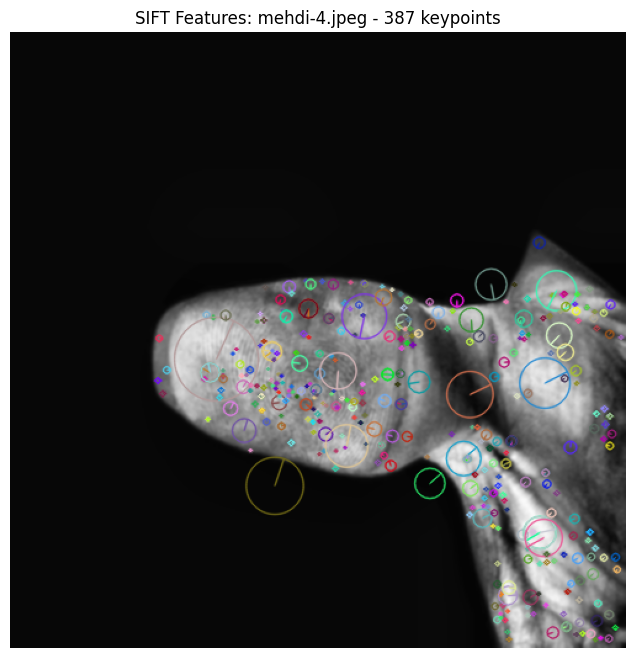

Saved visualization to output/mehdi-3_features.png


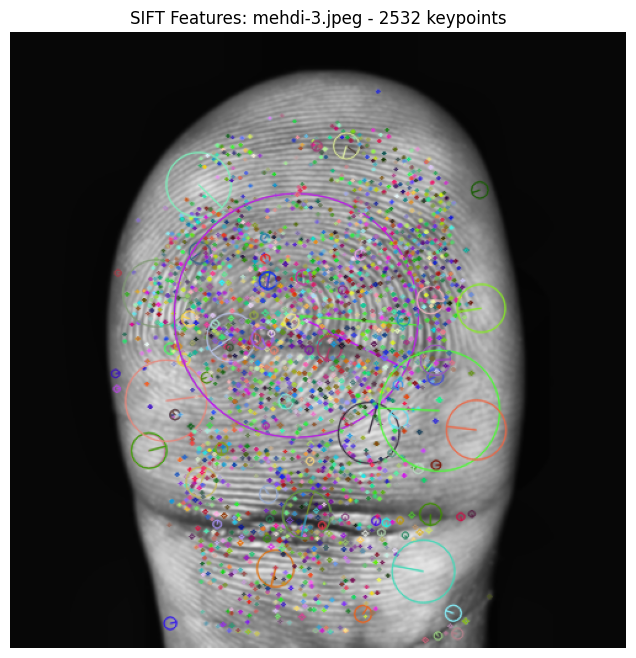

Saved visualization to output/roohan_features.png


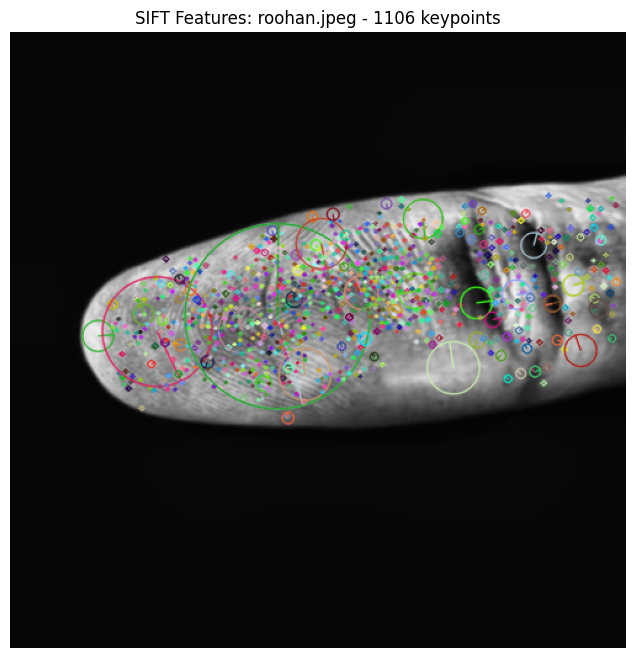

Saved visualization to output/ali_features.png


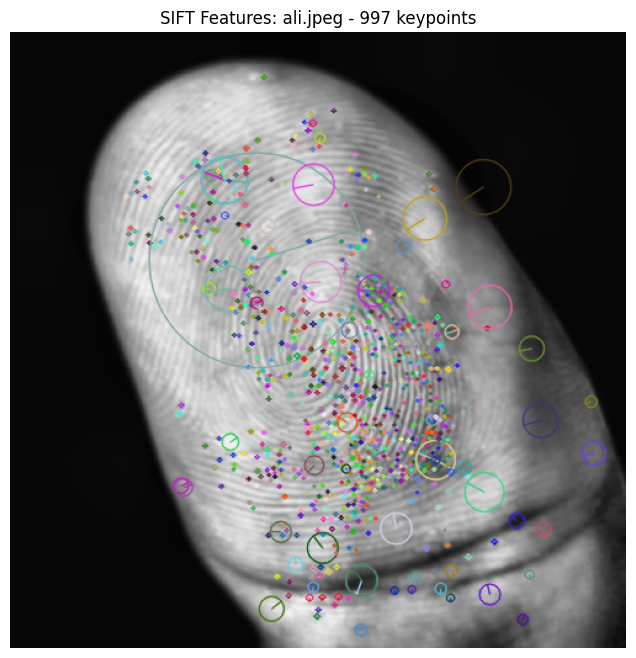

Saved visualization to output/ali-test_features.png


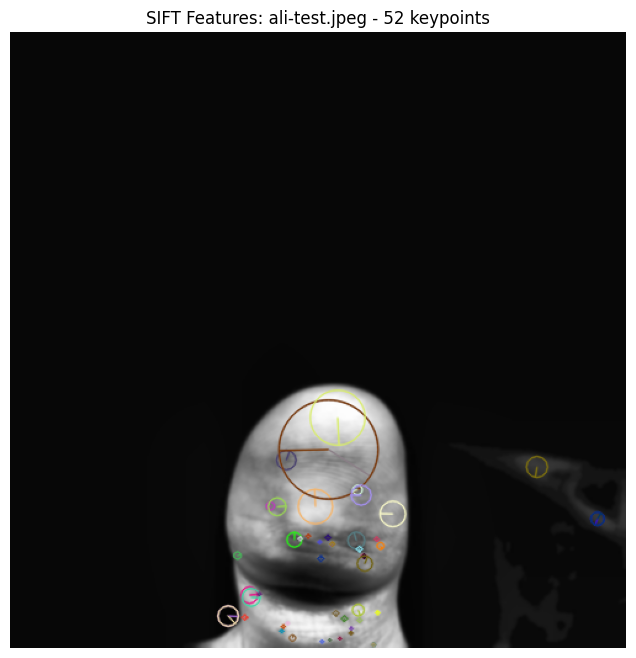


Testing fingerprint matching:
Using test image: test_data/ali-test (1).jpeg
Match score for mehdi-1: 0.0000 (good matches: 0)
Match score for uzain: 0.0000 (good matches: 0)
Match score for mehdi-2: 0.0049 (good matches: 1)
Match score for ali-test-2: 0.0299 (good matches: 2)
Match score for mehdi-4: 0.0000 (good matches: 0)
Match score for mehdi-3: 0.0000 (good matches: 0)
Match score for roohan: 0.0000 (good matches: 0)
Match score for ali: 0.0000 (good matches: 0)
Match score for ali-test: 1.0000 (good matches: 52)
Best match: ali-test with score: 1.0000 (52 good matches)
Saved visualization to output/match_visualization_ali-test (1).jpeg.png


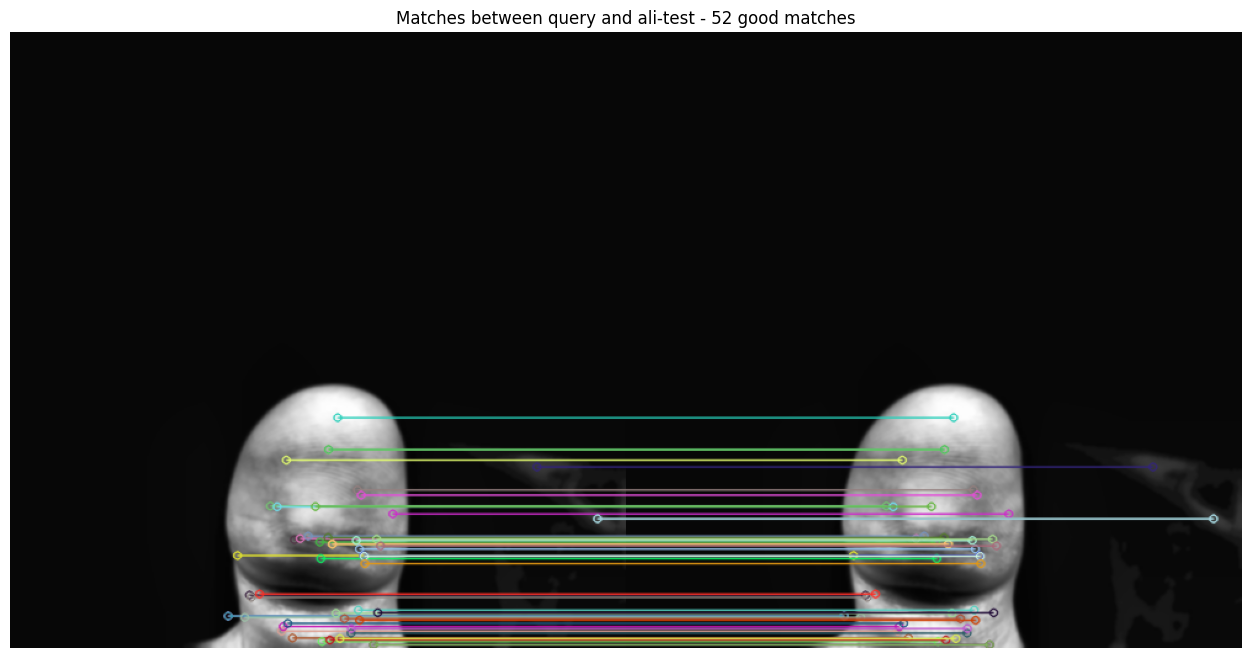

In [ ]:
import os

def main():
    # Directory containing fingerprint images
    data_dir = "processed_data"
    test_dir = "test_data"  # Directory for test images

    # Create fingerprint matcher
    matcher = FingerprintMatcher(data_dir)

    # Create output directory for visualizations
    os.makedirs("output", exist_ok=True)

    # Visualize SIFT features for each fingerprint
    print("\nVisualizing SIFT features for each fingerprint:")
    for person_id in matcher.fingerprint_db:
        image_path = os.path.join(data_dir, f"{person_id}.png")  # Assuming PNG format
        if not os.path.exists(image_path):
            # Try other formats
            for ext in [".jpg", ".jpeg", ".bmp"]:
                image_path = os.path.join(data_dir, f"{person_id}{ext}")
                if os.path.exists(image_path):
                    break

        save_path = os.path.join("output", f"{person_id}_features.png")
        matcher.visualize_features(image_path, save_path)

    print("\nTesting fingerprint matching:")

    # Loop through all images in test_data directory
    for test_image_name in os.listdir(test_dir):
        test_image = os.path.join(test_dir, test_image_name)
        if not os.path.isfile(test_image):
            continue  # Skip if it's not a file (e.g., subdirectory)

        print(f"Using test image: {test_image}")

        best_match, score, num_good_matches = matcher.match(test_image)
        print(
            f"Best match: {best_match} with score: {score:.4f} ({num_good_matches} good matches)"
        )

        if best_match:
            # Visualize matches
            save_path = os.path.join(
                "output", f"match_visualization_{test_image_name}.png"
            )
            matcher.visualize_matches(test_image, best_match, save_path)


if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')